In [46]:
### import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from astropy.io import fits
from scipy import signal

In [47]:
### load argon calibration quartic coefficient matrices
# Windows for cxh002  
filepath_calib = "C:/Users/cxh002/Documents/DSP_spectrum_calibration/"
#filepath_calib="/home/craig/Desktop/DSP_calib/" # Linux for craig


k0=np.load(filepath_calib+"k0.npy")
k1=np.load(filepath_calib+"k1.npy")
k2=np.load(filepath_calib+"k2.npy")
k3=np.load(filepath_calib+"k3.npy")
k4=np.load(filepath_calib+"k4.npy")


In [48]:
### load raw data
filepath_stardata="C:/Users/cxh002/Documents/DSP_spectrum_calibration/star_data_raw/"
starname="?"
hdulist = fits.open(filepath_stardata+"Capture_039.fit")  
print(repr(hdulist[0].header))
scidata=hdulist[0].data

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2749                                                  
NAXIS2  =                 2199                                                  
BZERO   =           32768.000000                                                
BSCALE  =             1.000000                                                  
DATAMIN =             0.000000                                                  
DATAMAX =           65535.000000                                                
INSTRUME=           'ATIK-460ex: fw rev 3.34'                                   
EXPTIME =           120.000                                                     
DATE-OBS=           '2019-11-02T01:38:49'                                       
XPIXSZ  =           4.540   

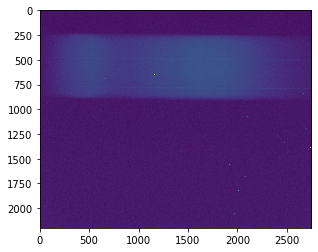

In [49]:
plt.imshow((scidata)**.1)


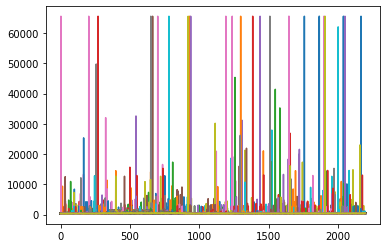

In [50]:
plt.plot(scidata);

Bad Pixels = 42173
i2500 = 692.0
y0 = 0
796 95


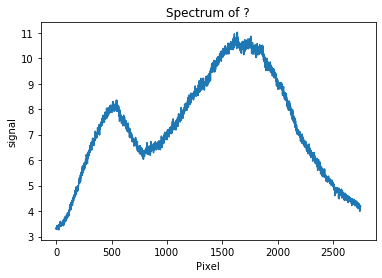

In [57]:
###Correct for exposure time
img=scidata/hdulist[0].header['EXPTIME']  #extract data per unit time
y0=hdulist[0].header['YORGSUBF']   #extract starting y line index from header

###Remove Bad Pixels###



import scipy.signal
img_sm = scipy.signal.medfilt(img, [1,3])
bad = (np.abs(img - img_sm) / 100) > .01
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
ind2=np.argmax(img_cr,0)
print("Bad Pixels =", sum(sum(bad)))

###Find indc "line" of Spectrum###
pix=np.arange(0,hdulist[0].header['NAXIS1'],1)
lines=np.arange(0,hdulist[0].header['NAXIS2'],1)

m=.0108 

i2500=np.mean(ind2[2490:2510])


print("i2500 =", i2500)
i2500=790

print("y0 =",y0)
b=i2500-m*2500
indc=m*pix+b
#plt.plot(indc)
#plt.plot(ind2)

###Weighted Average of Nearby Lines###
y=lines
indca, ya = np.meshgrid(indc, lines,indexing='xy')
#print(indca.shape)
sigma=5
w=1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(ya-indca)**2/(2*sigma**2))

###Converting Pixel to Wavelength###
#palpha=np.argmin(s2[2000:2500])+2000
#print(s2[palpha-1],s2[palpha],s2[palpha+1])
#plt.plot(s2[(palpha-30):(palpha+30)])
#m=0.005123
#b=55.616
#palphastar=2557
#pstar=pix+(m*pix+b)*(palphastar-palpha)/(m*palpha+b)

#pc=1375
#ka=5427.504919
#kb=1.011329125
#kc=-4.14239E-05
#kd=-6.61252E-09
#ke=4.787326E-12
#wl=ka+kb*(pstar-pc)+kc*(pstar-pc)**2+kd*(pstar-pc)**3+ke*(pstar-pc)**4

#plt.plot(wl,s2);
#plt.xlabel('wavelength (Angstroms)');
#plt.ylabel('signal');
#plt.title('Spectrum of Phecda')

###Plot Spectrum###
sd= np.sum(w*img_cr,0)

plt.plot(sd)
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)
print(np.max(ind2[2400:2600]),np.min(ind2[2400:2600]))

array([505, 790, 791, 505, 506], dtype=int32)

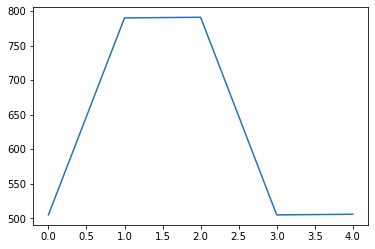

In [58]:
plt.plot(ind2[2500:2505])
ind2[2500:2505]

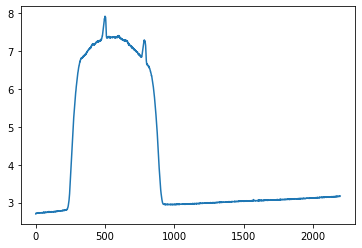

In [59]:
plt.plot(np.mean(img_cr,1));

(2749,)


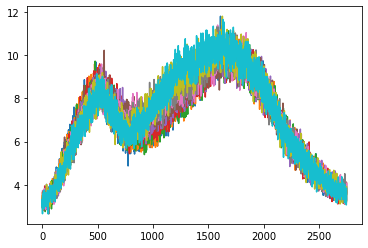

In [80]:
### find average signal in a dark part of slit
### compute background average and subtract off of spectrum

plt.plot(img_cr[770:780,:].T);
bg=np.mean(img_cr[770:780,:],0)
print(bg.shape)
sdbgs=sd

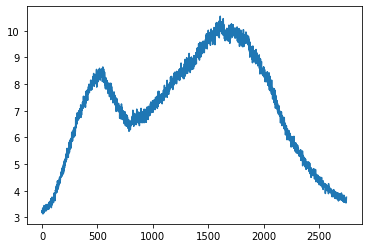

In [81]:
plt.plot(bg)

Text(0.5, 1.0, 'Spectrum of ?')

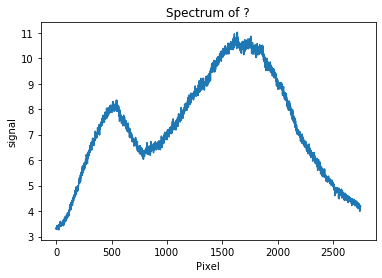

In [82]:
plt.plot(sdbgs)
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)

Text(0.5, 1.0, 'Spectrum of ?')

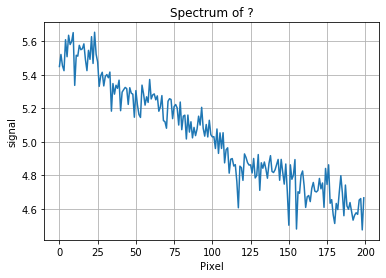

In [83]:
###calibrating pixel to wl based on Halpha. Have to look for a good range for Halpha feature here###
###Plot Spectrum, zooming in on feature ###

plt.plot(sdbgs[2400:2600])
plt.grid()
plt.xlabel('Pixel');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)


#found at 2400+117 =2517


In [84]:
# find index in used for this camera line (i2500woffset) in k matrix
i2500woffset=i2500+y0
print(i2500woffset)
print(y0)
lineindex=int(np.round(i2500woffset/10))
print(lineindex)

790
0
79


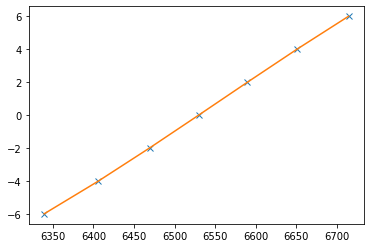

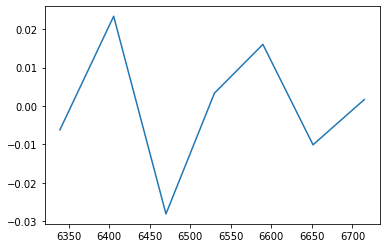

inferred xs =  1.101654927342679


In [85]:
### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database
wlfeature=6563
#this is wl of Halpha
pixpk=2517
#pixel where min or max is found in feature
### find xs so that pixfeature and wlfeature match calibration

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#plot of fit and data
plt.plot(wl,xs,'x');
plt.plot(wl,np.polyval(lfit,wl))
plt.show()

#residuals
plt.plot(wl,xs-np.polyval(lfit,wl));
plt.show()
#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)
print("inferred xs = ",xse)

[ 3.20897917e-12 -2.48223338e-08  2.62722058e-05  1.04614928e+00
  4.03012952e+03]


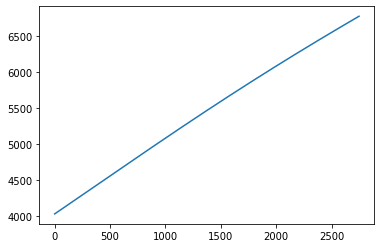

In [86]:
# linear interpolation

from scipy.interpolate import interp1d

f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")

km=f(xse)
print(km)
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)

plt.plot(pix,wle);

796 95


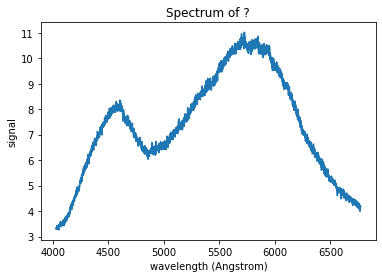

In [87]:
plt.plot(wle,sdbgs)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('signal');
plt.title("Spectrum of "+starname)
print(np.max(ind2[2400:2600]),np.min(ind2[2400:2600]))

In [88]:
np.save(filepath_calib+"CSspec",sdbgs)
np.save(filepath_calib+"CSwl",wle)
#This is where the calibrated spectrum is saved. I'm not sure what should be changed about this to make the calibrated spectra
#easier to find and read?

In [89]:
### now wavelength is calibrated

###smooth k matrices first?

In [90]:
transfuncM=np.load(filepath_calib+"transfuncM.npy")

In [91]:
# linear interpolation

wlMILES=3500+0.9*np.arange(4367)

from scipy.interpolate import interp1d

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)


Text(0.5, 1.0, 'Spectrum of ?')

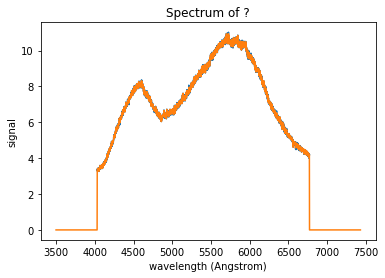

In [92]:
plt.plot(wle,sdbgs);
plt.plot(wlMILES,spM);
plt.xlabel('wavelength (Angstrom)');

plt.ylabel('signal');
plt.title("Spectrum of "+starname)

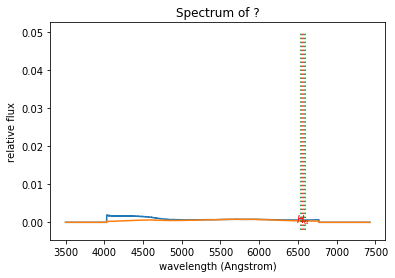

In [93]:
###This is final spectrum
siM=spM/transfuncM
plt.plot(wlMILES,siM)
plt.plot(wlMILES,spM/max(transfuncM))
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.002, 0.05), ":r")
plt.plot((6535.7,6535.7), (-0.002, 0.05), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.002, 0.05), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");



In [94]:
### finding index for each Hydrogen line 
###(trying indices manually until they are the nearest WL below the Hydrogen line)
print(wlMILES[3404],wlMILES[1513],wlMILES[934],wlMILES[669])

6563.6 4861.7 4340.6 4102.1


6563.6
0.9709969812626397


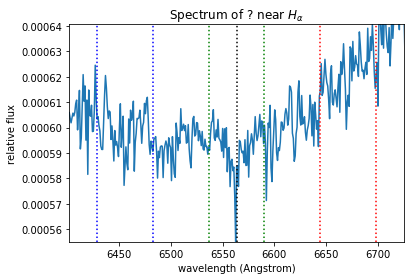

In [95]:
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih=3404
ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150


s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(wlMILES[ih])
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\alpha$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsigha=normsigh

0.9198071004506038


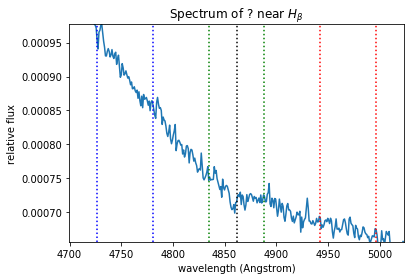

In [96]:
ih=1513

ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\beta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsighb=normsigh

1.0353943113475181


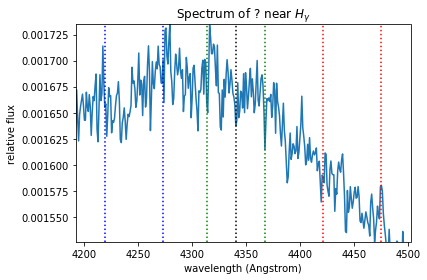

In [97]:
ih=934


ihb=ih-30
iht=ih+30
ihvb=ih-135
ihvt=ih-75
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\gamma$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsighc=normsigh

1.876668357272588


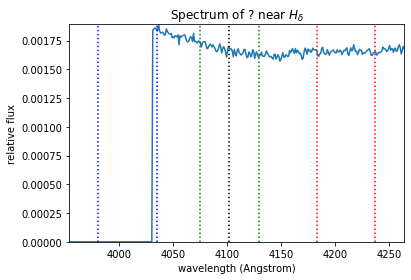

In [98]:
ih=669


ihb=ih-30
iht=ih+30
ihvb=ih-135
ihvt=ih-75
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\delta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsighd=normsigh

In [96]:
print(normsigha,normsighb,normsighc,normsighd)

1.4030744730377143 1.0161936586799596 1.0293850810148402 0.11802863966874048
